# INTRODUCTION TO JULIA: Reads** like Python, has** C speed and LISP macros

## Setup

+ Ubuntu package 
+ [Download](http://julialang.org/downloads/) binaries (all platforms)
+ Build from source code
```
git clone https://github.com/JuliaLang/julia.git
cd julia
make -j 4
```
+ Try Julia in your browser via [JuliaBox](https://www.juliabox.org/). No installation but Google account required

## First steps
Julia code can be run similar to Python, i.e. (i) by writing the code to file and then passing it to the executable
```julia
msg = "Hello World"
if length(ARGS) > 0
    msg = msg * " & $(first(ARGS))!"
else
    msg = msg * "!"
end

println(msg)

```
and then
```bash
julia hello_world.jl
```
or (ii) via REPL

## First steps inside the notebook
- We will need an IJulia kernel for jupyter notebook
- For installation use the built in package manager
```
using Pkg
Pkg.add("IJulia")
```

In [2]:
using Pkg
Pkg.add("IJulia")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [3]:
# Note that (unlike numpy) the vectors are column vectors, not row vectors
A = [1, 2, 3, 4];
# Here, ";" after the statement supresses the output

In [4]:
# 1-based indexing as if matlab
first(A) == A[1]

true

In [5]:
# Some other matlab influence
B = A.^2;   # not A**2

foreach(x -> println(x), B)

1
4
9
16


In [6]:
# Just showing off unicode
# Type \notin and tab-complete (like Latex)
2 ∉ A

false

In [7]:
# Checking subsets
b = Set([2, 3]);
a = Set(A);  
# ; supresses printing the result of last expression
#NOTE: the value assignment `a = rhs` is rhs

In [8]:
a < b

false

Same as in Python we can can if b is a subset of a as `b < a`. But if you got used on the beauty of $\in$ you might find it hard to settle for `<`. So let's define our first function 

In [9]:
⊂(a, b) = a < b

⊂ (generic function with 1 method)

In [10]:
# Testdrive
b < a && b ⊂ a 

true

## What is Julia ?
+ Julia: A fresh approach to numerical computing, see [paper](http://arxiv.org/abs/1411.1607) and [thesis](https://github.com/julialang/julia/issues/8839)
+ High level, dynamic, (dynamically) typed, general purpose language
+ Free and open-source. MIT licence
+ Went [viral](https://www.google.com/trends/explore#q=julia%20language) on Valentine's day 2014
+ Some features we will see in action today
    - type inference
    - JIT compiler
    - rich typestem
    - multiple dispatch
    - zero overhead C/Fortran calls 
    - metaprogramming
+ Version 1.8 now. First stable 1.0 release in 2019

## Why do we need yet another language?

Short answer - to address the two language paradigm
+ Express the idea in high level language(Python) - setup prototype quickly. Performance far from production code
+ Production code then written in low level language (C/C++)
+ Write performance critical parts of code in low level language and glue together ([Numba](http://numba.pydata.org/), SWIG)
    - FEniCS uses Python to generate C++ code (see poisson.ufl, poisson.h) that is compiled and wrapped for Python
    - [Some people](http://www.sciencedirect.com/science/article/pii/S0010465516300200) prototype in Python/NumPy and then write the same code in [Cython](https://github.com/spectralDNS/spectralDNS/blob/master/spectralDNS/optimization/cython_maths.in)
+ To extend NumPy/SciPy you (usually) have to write C
+ Machine learning frameworks like Tensorflow or Pytorch more-or-less also only use Python to declare the computation graph which is then crunched into C++ code

Julia's approach
+ Designed to be easy to write with performance close to C
+ If that is true you need one language to solve your problem
+ It seems to be true: benchmarks from the Julia website

# Some benchmark problems of our own

## Project Euler problem 14. 
The following iterative sequence is defined for the set of positive integers:

+ n → n/2 (n is even)
+ n → 3n + 1 (n is odd)

Using the rule above and starting with 13, we generate the following sequence: 13 → 40 → 20 → 10 → 5 → 16 → 8 → 4 → 2 → 1. Which starting number, under one million, produces the longest chain? Note that whether the chain terminates for arbitrary $n$ is an unproved conjecture.

+ To solve PE problem's the solution must be obtained in less then 60s. Honor code is to beat 1s.
+ Note that the code presented here is a bruteforce solution
+ The answer it produces is correct

In [11]:
"""Compute the Collatz chain for number n."""
function collatz_chain(n)
    k = 1
    while n > 1
        n = isodd(n) ? 3n+1 : n >> 1
        k += 1
        # println(n)
    end
    k
end

"""Which of the number [1, stop) has the longest Collatz chain."""
function solve_euler(stop)
    n, N, N_max = 1, 0, 0  
    while n < stop
        value = collatz_chain(n)
        if value > N_max
            N = n
            N_max = value
        end
        n += 1
    end
    (N, N_max)
end

solve_euler

In [12]:
# Let's time it
N = 1000000
answer = @time solve_euler(N)
answer

  0.173992 seconds (7.38 k allocations: 372.607 KiB, 4.97% compilation time)


(837799, 525)

Julia is done in about 0.2s, Python need ~11s (cf the accompanying notebook). So with Julia I am onto the next problem. With Python it is back to the drawing board. Note that the first time you run the code, the timing is slow(er) because of the Just In Time compiler.

## Julia fractal
+ It is only approprate that we explore the Julia set
+ Explore points $z$ in the complex plain such that $z_{n+1}=z^2_{n}+c$ is bounded for any n

In [13]:
# Julia code is a translation of the definition
"""Color Julia set. Code from https://www.youtube.com/watch?v=PsjANO10KgM"""
function julia(z, c)
    for n in 1:80
        if abs2(z) > 4
            # Color by iterations
            return n-1
        end
        z = z*z + c
    end
    return 80
end

"""Color Julia set. Prealoc version"""
function julia(x, y, c)
    J = zeros(length(x), length(y))
    index = 0
    for r in y, i in x
        index += 1
        # Flat indexing
        J[index] = julia(complex(r, i), c)
    end
    J
end

julia

Few things to observe
- We have defined `julia` functions differing by signatures. Which one gets called when the code is run is our first encounter with _multiple dispatch_.
- `J[index]` is the flattened indexing

In [14]:
# We explore a few points
cs = (complex(-0.06, 0.67), complex(0.279, 0), complex(-0.4, 0.6), complex(0.285, 0.01))

x = collect(1:-0.002:-1);
y = collect(-1.5:0.002:1.5);

Js = []
# Evaluate fractal generation
t0 = time()
for c in cs
    # No prealoc 0.4s
    # push!(Js, [julia(complex(r, i), c) for i in x, r in y]);
    # Prealoc out 0.35s
    push!(Js, julia(x, y, c));
end
t1 = time()

print("Generated in $(t1-t0)f s\n");
println("Image size $(size(Js[1], 1))x$(size(Js[1], 2))")

Generated in 0.41959404945373535f s
Image size 1001x1501


In [15]:
using Pkg
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


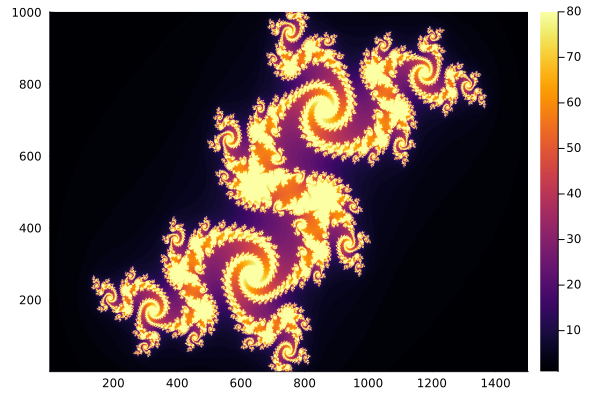

In [16]:
using Plots
heatmap(first(Js))

Python requires close to 3s to generate the fractals. With either of the Julia versions the execution time is close to 1s.

# Writing code like Python

+ Illustrate workflow by a made example of postprocessing 
+ Below we mostly avoid being explicit about types on purpose

In [17]:
# Reading from file. How many words in the MIT licence?
LICENCE = open("./LICENSE")
content = map(lowercase, read(LICENCE, String))
words = split(content, r"\W+")
close(LICENCE)
length(words)

173

In [18]:
# We could have done this with bash.
# Shell interoperatbility `(backtick)
cmd = pipeline(`cat LICENSE`, `wc -w`)
run(cmd)  # 173 vs 171, less than 1% error is okay:)

171


Base.ProcessChain(Base.Process[Process(`cat LICENSE`, ProcessExited(0)), Process(`wc -w`, ProcessExited(0))], Base.DevNull(), Base.DevNull(), Base.DevNull())

In [19]:
# Are all these words unique?
unique_words = Dict()
for word ∈ words
    unique_words[word] = get(unique_words, word, 0) + 1
end
length(keys(unique_words))

98

In [20]:
unique_words

Dict{Any, Any} with 98 entries:
  "deal"          => 1
  "permission"    => 2
  "action"        => 1
  "notice"        => 2
  "documentation" => 1
  "following"     => 1
  "warranties"    => 1
  "permit"        => 1
  "conditions"    => 1
  "obtaining"     => 1
  "an"            => 1
  "2022"          => 1
  "purpose"       => 1
  "express"       => 1
  "of"            => 8
  "use"           => 2
  "as"            => 1
  "to"            => 8
  "liable"        => 1
  "associated"    => 1
  "warranty"      => 1
  "sell"          => 1
  "contract"      => 1
  "tort"          => 1
  "sublicense"    => 1
  ⋮               => ⋮

In [21]:
# What are the most common?
for (_, (k, v)) in zip(1:5, sort(collect(unique_words), by=last, rev=true))
    println("$(k) $(v)")
end

the 15
software 9
or 9
of 8
to 8


Note that collect unique makes a list by iterating over the dictionary. This iterations is over KEY-VALUE pairs. This is unlike Python. Let's see what else is different.

In [22]:
# iteration is over (key, values) pairs
for (key, value) in zip(1:4, collect(unique_words))
    println("$key => $value")  # "%.4g" % (...)
end

1 => Pair{Any, Any}("deal", 1)
2 => Pair{Any, Any}("permission", 2)
3 => Pair{Any, Any}("action", 1)
4 => Pair{Any, Any}("notice", 2)


In [23]:
# : is => in the dictionary construction
dict = Dict(1 => "one", 2 => "two")

Dict{Int64, String} with 2 entries:
  2 => "two"
  1 => "one"

In [24]:
# in checks for (key, value) pair
haskey(dict, 1), (1 => "en") ∈ dict

(true, false)

In [25]:
typeof(1 => 2)

Pair{Int64, Int64}

In [26]:
# String concatenation is done with *. With + the operation should be commutative, which is not the case here
"Julia" * " Language"

"Julia Language"

In [27]:
# A direct consequence of this is ...
"Julia"^5

"JuliaJuliaJuliaJuliaJulia"

In [28]:
# / is for floating point division. Integer division is done by div. Rational numbers are built it
/(7, 4), div(7, 4), 7÷4, 7 // 4

(1.75, 1, 1, 7//4)

In [29]:
# Indexing starts at one. The last element in range is included. 0..last not included has same length as 1..last included
a = [1, 2, 3]
try
    a[0]
catch BoundsError
    println("No no, a[1]=", a[1], " ", a[end] == a[3] == 3)
end

collect(1:10)[10] == 10

No no, a[1]=1 true


true

In [30]:
# Convenience
x = 4
y = 2x  # no *
y == 8

true

In [31]:
# List comprehensions. More convenience; save one "for"
[(i, j) for i in 1:4, j in "abcd"]

4×4 Matrix{Tuple{Int64, Char}}:
 (1, 'a')  (1, 'b')  (1, 'c')  (1, 'd')
 (2, 'a')  (2, 'b')  (2, 'c')  (2, 'd')
 (3, 'a')  (3, 'b')  (3, 'c')  (3, 'd')
 (4, 'a')  (4, 'b')  (4, 'c')  (4, 'd')

In [32]:
# Contrast this with Python
A = reshape(collect(1:25), (5, 5))

5×5 Matrix{Int64}:
 1   6  11  16  21
 2   7  12  17  22
 3   8  13  18  23
 4   9  14  19  24
 5  10  15  20  25

In [33]:
# In numpy you get to iterate over rows of matrix (for vectorization). In Julia this is not default. 
entries = [e for e in A]  #join(map(string, collect(A)), ", ")
# Moverover, columns are contiguous so accessing rows is not efficient.
# Finaly you iterate over values not pointers
for a in A
    a += 1
end
A

5×5 Matrix{Int64}:
 1   6  11  16  21
 2   7  12  17  22
 3   8  13  18  23
 4   9  14  19  24
 5  10  15  20  25

In [34]:
for i in eachindex(A)
    A[i] += 1
end
A 

5×5 Matrix{Int64}:
 2   7  12  17  22
 3   8  13  18  23
 4   9  14  19  24
 5  10  15  20  25
 6  11  16  21  26

In [35]:
# Column majored linear indexing
A[8] == 9

true

In [36]:
A = [1 2; 3 4] # 2x2 
B = [1, 2]     # 2 x 1
C = [1 2]      # 1 x 2
A

2×2 Matrix{Int64}:
 1  2
 3  4

Finally a quick look at functions

In [37]:
# One lined named function definition
f(x, y) = 2x + 4y   # Define
f(1, 0) == 2  # Call

true

In [38]:
# Implicit return statements
function f(name)
    if isequal(name, "Sparta")
        return "This is " * name * "!"
    end
    name  # Implicit return
end

(f("London"), f("Sparta")) == ("London", "This is Sparta!")

true

In [39]:
# Variable positional arguments
mysum(args...) = join(map(string, args), "+")
mysum(10, 20)

"10+20"

In [40]:
# Higher order functions with keywords arguments
foo(x; op=+) = op(x, 1)

foo (generic function with 1 method)

In [41]:
[foo(1), foo(2; op=-), foo(4; op=*)]

3-element Vector{Int64}:
 2
 1
 4

In [42]:
# Lambdas: remove vowels
vowels = ('a', 'e', 'i', 'o', 'u', 'y')
map(word -> filter(l -> (l ∉ vowels), word), Tuple(keys(unique_words)))
# Tuple(keys(unique_words))

("dl", "prmssn", "ctn", "ntc", "dcmnttn", "fllwng", "wrrnts", "prmt", "cndtns", "btnng", "n", "2022", "prps", "xprss", "f", "s", "s", "t", "lbl", "ssctd", "wrrnt", "sll", "cntrct", "trt", "sblcns", "s", "whthr", "nd", "ncldng", "ftnss", "fr", "sftwr", "cprght", "n", "lmttn", "mrg", "d", "knd", "sbstntl", "shll", "thr", "nnnfrngmnt", "lcns", "cnnctn", "c", "pblsh", "n", "cps", "bv", "grntd", "nt", "bt", "sbjct", "cp", "fr", "mdf", "mrchntblt", "r", "hldrs", "rsng", "mpld", "b", "clm", "wth", "hrb", "dlngs", "mt", "dstrbt", "n", "vnt", "prsns", "s", "chrg", "dmgs", "lmtd", "", "ths", "fls", "thrws", "t", "ncldd", "prtclr", "th", "prtns", "wtht", "prsn", "rstrctn", "prvdd", "ll", "whm", "frnshd", "kcht", "rghts", "mrslv", "lblt", "", "frm", "thrs")

In [43]:
# Specifying types for functions
# Parametric function: for any Matrix where the valuetype is subtype of Real
function trace(A::Matrix{T} where T<:Real)
    nrows, ncols = size(A)
    @assert nrows == ncols
    sum(A[i, i] for i in 1:nrows)
end

A = rand(2, 2)
(A, trace(A))

([0.49859348130508363 0.5555279638246072; 0.909886888870762 0.7599579412789877], 1.2585514225840715)

In [44]:
# Won't work with complex
B = im*rand(2, 2)

println(eltype(B))

try
    trace(B)
catch e
    println(e)
end

ComplexF64
MethodError(trace, (ComplexF64[0.0 + 0.17633834851868502im 0.0 + 0.4721226997858763im; 0.0 + 0.06435092087937866im 0.0 + 0.26777198433705185im],), 0x0000000000007f06)


# Interoperability with Python
+ The whole Python ecosystem can be reached via Julia package PyCall  (`Pkg.add("PyCall")`)

In [45]:
Pkg.add("PyCall")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [46]:
using PyCall

In [47]:
# Use python iteratorors
@pyimport itertools as iter
A = (1, 2, 3)          # Julia matrix
for i ∈ iter.product(A, A)  # Call with Julia input
    println(i)
end# Passed to python no copying

(1, 1)
(1, 2)
(1, 3)
(2, 1)
(2, 2)
(2, 3)
(3, 1)
(3, 2)
(3, 3)


In [48]:
# Let's have numpy make the matrix and then Julia takes over for the actual work
@pyimport numpy as np
Apy = np.diag([1, 2, 3, 4])  # Note that this is Julia array passed to Numpy which comes back as a Julia matrix

using LinearAlgebra

eigvals(Apy)  # Call Julia function with Python input

4-element Vector{Float64}:
 1.0
 2.0
 3.0
 4.0

In [49]:
Pkg.add("PyPlot")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


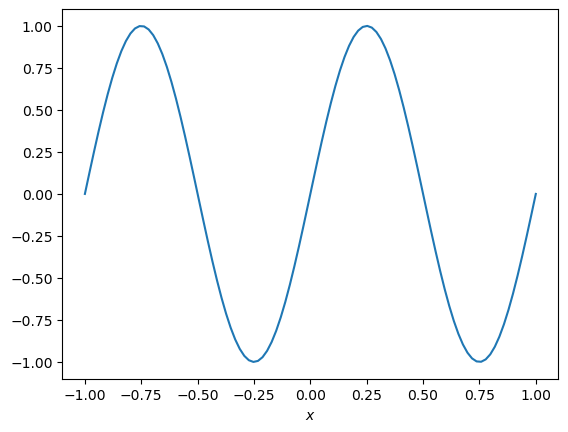

In [50]:
using PyPlot  # Calls into matplotlib

# Julia has native packages for plotting, but why give up matplotlib
x = range(-1, 1, length=100)
y = sin.(2π*x)  # NOTE: dot syntax
figure()
PyPlot.plot(x, y)
xlabel("\$x\$")  # Note that dollars have to be escaped for they have special role in Julia's string (interpolation)
show()

# Some of Julia's magic (reasons for speed)

Warning: I do not know/understand the whole story. It seems magical. That said, let me quote the Julia manual:

> Clever application of sufficiently advanced technology can be indistiguishable from magic (A. C. Clarke)

## Compiler

In [51]:
#Your code is parsed, type annotated(types can be inferred). 
simplef(x, y) = x + y
simplef(1, 2)

@code_warntype simplef(1, 2)   # Types based on input

MethodInstance for simplef(::Int64, ::Int64)
  from simplef(x, y) in Main at In[51]:2
Arguments
  #self#::Core.Const(simplef)
  x::Int64
  y::Int64
Body::Int64
1 ─ %1 = (x + y)::Int64
└──      return %1



In [52]:
# When f is called with specific values JIT compiles the function. With type annotation the compiler can reason about
# the code and generate efficient code.
@code_llvm simplef(1, 2)      # Note @julia_simplef_FOO(i64, i64)

;  @ In[51]:2 within `simplef`
define i64 @julia_simplef_12246(i64 signext %0, i64 signext %1) #0 {
top:
; ┌ @ int.jl:87 within `+`
   %2 = add i64 %1, %0
; └
  ret i64 %2
}


In [53]:
# Different value types will invoke JIT again
@code_llvm simplef(1, 2.)        # @julia_simplef_BAR(i64, double)

;  @ In[51]:2 within `simplef`
define double @julia_simplef_12269(i64 signext %0, double %1) #0 {
top:
; ┌ @ promotion.jl:388 within `+`
; │┌ @ promotion.jl:359 within `promote`
; ││┌ @ promotion.jl:336 within `_promote`
; │││┌ @ number.jl:7 within `convert`
; ││││┌ @ float.jl:146 within `Float64`
       %2 = sitofp i64 %0 to double
; │└└└└
; │ @ promotion.jl:388 within `+` @ float.jl:383
   %3 = fadd double %2, %1
; └
  ret double %3
}


## Type system
All values have types. You can type annotate your variables. This is not really for performance. Rather, you declare your intensions better.

In [54]:
map(typeof, (1, 2., [1, 2.]))

(Int64, Float64, Vector{Float64})

In [55]:
# This reads as is lhs an instance of rhs
1::Number, 1::Real, 1::Int

(1, 1, 1)

In [56]:
# But 
try
    1::Int8
catch TypeError
    println("Type of 1 is $(typeof(1)) and that is not a subtype of Int8")
end

Type of 1 is Int64 and that is not a subtype of Int8


The type hierarchy is appearing.

In [57]:
depth = 0
function printtypes(T)
    global depth
    if isconcretetype(T)
        println("-"^(2*depth), "$T")
    else
        println("-"^depth, "$T")
        depth += 1
        map(printtypes, subtypes(T))
        depth -= 1
    end
end

printtypes(Real)  # Loong wait. Listen to the fan - silly ideas make sounds

Real
-AbstractFloat
----BigFloat
----Float16
----Float32
----Float64
-AbstractIrrational
--Irrational
-FixedPointNumbers.FixedPoint
--FixedPointNumbers.Fixed
--FixedPointNumbers.Normed
-Integer
----Bool
--Signed
------BigInt
------Int128
------Int16
------Int32
------Int64
------Int8
--Unsigned
------UInt128
------UInt16
------UInt32
------UInt64
------UInt8
-Rational
--StatsBase.PValue
--StatsBase.TestStat


0

+ In the type tree the nodes are _abstract_ types and the leafs are _concrete_ types.
+ The abstract types express concepts and there are no instances of it but singletons. 
+ The concete types can have instances but cannot be subtyped.

## Multiple dispatch

If types are specified in the functions signature the compiler (first compiles and then) calls appropiate function based on the type of all the arguments. That is, unlike in OO programing, it is not the first type that owns the method. There is nothing special about the first argument; think `Int.__add__(self, other)` in Python. 

In [58]:
# + is a function +(x, y) = ... . Which one is called based on args
@which +(1, 3)

+(x::T, y::T) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} in Base at int.jl:87

In [59]:
@which 0x1+0x3
# Same as args agree in types from the union

+(x::T, y::T) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} in Base at int.jl:87

In [60]:
@which 1+2.
# Different

+(x::Number, y::Number) in Base at promotion.jl:388

New types can be defined easily. In the example we'd like to represent functions given by their sine series.

In [61]:
"""Polynomial with value c[i]*sin(i*pi*x)"""
struct SinePolynomial{T}
    coefs::Vector{T}
end

SinePolynomial

In [62]:
# If not specified otherwise our parent is Any - the very tip of the type tree
supertype(SinePolynomial)

Any

In [63]:
# Our type is composite i.e. has fields
fieldnames(SinePolynomial)

(:coefs,)

To add 'its methods' we define functions with the new type. These are added to the dispatcher's system and called when needed.

In [64]:
import Base: +, -
# Add () for evaluating the polynomial
# Note that we are defining SinePolynomial such that the coefficients can have any type.
# That (conrete) type is referred to by T
(p::SinePolynomial{T} where {T})(x::Real) = sum([c*sin(k*π*x) for (k, c) in enumerate(p.coefs)])

p = SinePolynomial([1, 2, 3])
p(2)  # Call (With Int) works as that's a subtype of real

# We can add/subtract polynomials. This is simple because of othogonality
# Again we can add p, q with coefficients of 2 different types
function +(p::SinePolynomial{T}, q::SinePolynomial{S}) where {T} where {S}
    np, nq = length(p.coefs), length(q.coefs)
    n = max(np, nq)
    p = [p.coefs; zeros(T, n-np)]
    q = [q.coefs; zeros(T, n-nq)]
    SinePolynomial(p+q)
end

function -(p::SinePolynomial{T}, q::SinePolynomial{S}) where {T} where {S}
    np, nq = length(p.coefs), length(q.coefs)
    n = max(np, nq)
    p = [p.coefs; zeros(T, n-np)]
    q = [q.coefs; zeros(T, n-nq)]
    SinePolynomial(p-q)
end

plus_methods = methods(+)
# See that + has been added to lookup table for dispatching
filter(m -> contains(String(m.file), "In"), plus_methods)

[1] +(p::SinePolynomial{T}, q::SinePolynomial{S}) where {S, T} in Main at In[64]:12

In [65]:
import Base.*
# We better prevent multiplications
*(p::SinePolynomial{T}, q::SinePolynomial{S}) where {T} where {S} = throw(ArgumentError("No multiplication until CosinePolynomial"))

p = SinePolynomial([1, 2, 3])
q = SinePolynomial([2, -1])

try
    p*q
catch ArgumentError
    println("Is it okay? ", applicable(*, (typeof(p), typeof(q))))
    nothing
end

Is it okay? false


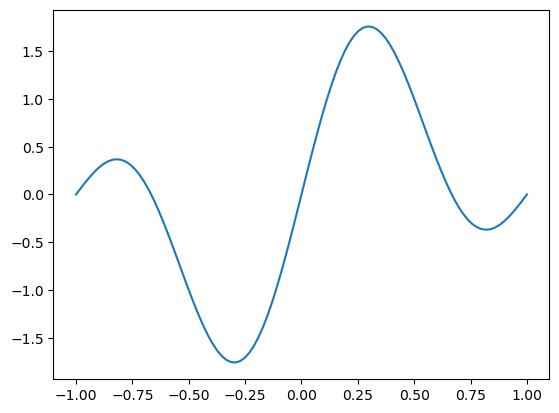

In [66]:
p = SinePolynomial([1]) + SinePolynomial([0, 1])
x = range(-1, 1, 100)
y = p.(x)  # NOTE: we never wrote () for arrays; . here automatically does broadcasting

using PyPlot  # Another python interoperability (calls to matplolib)

figure()
PyPlot.plot(x, y)
show()

## Type stability
+ You do not have to talk about types when writing Julia code
+ Compiler does its best to remove uncertainties about types when analyzing the code but this is not always possible
+ The generated code must then handle the uncertainty, unboxing
+ Consider this example (taken from the old Introducing Julia and Julia manual)

In [67]:
# Type INstability of s
function unstable(n)
    s = 0          # S is int
    for i in 1:n
        s += s/i   # S is Float
    end
    s
end

# Type stability of s
function stable(n)
    s = 0.0         # S is Float
    for i in 1:n
        s += s/i   # S is Float
    end
    s
end

stable (generic function with 1 method)

Let's compare the speed

In [68]:
@time stable(1000000)

  0.005284 seconds


0.0

In [69]:
@time unstable(1000000)  # Small but noticibly slower (was really noticible in older versions)

  0.006388 seconds


0.0

In [70]:
# Below note the uncertainty of the compiler about the return value; Union vs Definite type [unstable vs stable] 
# NOTE: 
code_warntype(unstable, (Int, ))  # Or @code_warntype unstable(1)   [some value that has int type]
println("="^10)
code_warntype(stable, (Int, ))

MethodInstance for unstable(::Int64)
  from unstable(n) in Main at In[67]:2
Arguments
  #self#::Core.Const(unstable)
  n::Int64
Locals
  @_3::Union{Nothing, Tuple{Int64, Int64}}
  s::Union{Float64, Int64}
  i::Int64
Body::Union{Float64, Int64}
1 ─       (s = 0)
│   %2  = (1:n)::Core.PartialStruct(UnitRange{Int64}, Any[Core.Const(1), Int64])
│         (@_3 = Base.iterate(%2))
│   %4  = (@_3 === nothing)::Bool
│   %5  = Base.not_int(%4)::Bool
└──       goto #4 if not %5
2 ┄ %7  = @_3::Tuple{Int64, Int64}
│         (i = Core.getfield(%7, 1))
│   %9  = Core.getfield(%7, 2)::Int64
│   %10 = s::Union{Float64, Int64}
│   %11 = (s / i)::Float64
│         (s = %10 + %11)
│         (@_3 = Base.iterate(%2, %9))
│   %14 = (@_3 === nothing)::Bool
│   %15 = Base.not_int(%14)::Bool
└──       goto #4 if not %15
3 ─       goto #2
4 ┄       return s

MethodInstance for stable(::Int64)
  from stable(n) in Main at In[67]:11
Arguments
  #self#::Core.Const(stable)
  n::Int64
Locals
  @_3::Union{Nothing, Tup

In [71]:
# And see about the length of the code that gets generated 67 vs 37
code_llvm(unstable, (Int, ))  
println("="^10)
code_llvm(stable, (Int, ))

;  @ In[67]:2 within `unstable`
define { {}*, i8 } @julia_unstable_13144([8 x i8]* noalias nocapture align 8 dereferenceable(8) %0, i64 signext %1) #0 {
top:
;  @ In[67]:4 within `unstable`
; ┌ @ range.jl:5 within `Colon`
; │┌ @ range.jl:393 within `UnitRange`
; ││┌ @ range.jl:400 within `unitrange_last`
     %.inv = icmp sgt i64 %1, 0
     %. = select i1 %.inv, i64 %1, i64 0
; └└└
  br i1 %.inv, label %L18, label %union_move21

L18:                                              ; preds = %L67, %top
; ┌ @ range.jl:879 within `iterate`
   %.sroa.028.0 = phi i64 [ %9, %L67 ], [ 0, %top ]
   %value_phi4 = phi i64 [ %8, %L67 ], [ 1, %top ]
   %value_phi6 = phi i1 [ false, %L67 ], [ true, %top ]
; └
;  @ In[67]:5 within `unstable`
  br i1 %value_phi6, label %L31, label %L26

L26:                                              ; preds = %L18
; ┌ @ promotion.jl:391 within `/`
; │┌ @ promotion.jl:359 within `promote`
; ││┌ @ promotion.jl:336 within `_promote`
; │││┌ @ number.jl:7 within `convert`

# Interoperability with C

+ C (and fortran) functions available in shared libraries can be accessed via `ccall`
+ In this case Julia's JIT generates code such calling the C function from Julia is as fast as the call from native C
+ The arguments to `ccall` are function name, library, return type, tuple of input types and the values for input parameters

Polynomial evaluation using GNU scientific library. Parametrized functions, restricted types (only Real coefs).
The signature of [gsl_poly_val](https://www.gnu.org/software/gsl/manual/html_node/Polynomial-Evaluation.html#Polynomial-Evaluation)


In [72]:
# Polynomial evaluation using GNU scientific library. Parametrized functions, restricted types
"""Evaluate polynomial c[1]*x^0 + c[2]*x^1 ... at x"""
function polyval(c::Vector{T} where T, x::S where S)
    c = convert(Vector{Float64}, c)
    n = length(c)
    value = ccall((:gsl_poly_eval, "libgsl"), Cdouble, (Ptr{Cdouble}, Cint, Cdouble), c, n, x)
    Float64(value)
end

polyval

In [73]:
using Plots

# Plot some random polynomials
x = collect(-1:0.1:1) 

ys = []
for i in 1:4
    c = rand(5)
    y = map(x -> polyval(c, x), x)
    push!(ys, y)
end

Plots.plot(x, ys)  # Specify module

LoadError: could not load library "libgsl"
libgsl.so: cannot open shared object file: No such file or directory

## Batteries included 

+ Julia has a very large scientific stack, e.g. FFT (FFTW by Steven G. Johnson), LA(LAPACK, BLAS, SuiteSparse), statistics
+ You can use existing Python modules(`PyCall`), existing C/Fortran libraries(`ccall`)
+ Some other (personal favourites): [IterativeSolvers.jl](https://github.com/JuliaMath/IterativeSolvers.jl), [PETSc.jl](https://github.com/JuliaParallel/PETSc.jl)
[Lazy.jl](https://github.com/MikeInnes/Lazy.jl), [JuMP.jl](https://jump.dev/JuMP.jl/stable/)

In [74]:
# And many more ...
using Pkg
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /home/mirok/Documents/Software/julia/usr/share/julia/stdlib/v1.8/Pkg/src/Pkg.jl:675


Dict{String, VersionNumber} with 6 entries:
  "StaticArrays" => v"1.5.11"
  "IJulia"       => v"1.23.3"
  "Plots"        => v"1.36.6"
  "PyPlot"       => v"2.11.0"
  "PyCall"       => v"1.94.1"
  "FFTW"         => v"1.5.0"

Let's show off a bit of linear algebra features.

In [75]:
using LinearAlgebra

# The favourite Poisson problem on UnitInterval. Convergence of CG1 FEM
A = 0  # Keep A outside for loop
for ncells in [2^i for i in 8:14]
    h = 1/ncells
    x = Float64[h*i for i in 0:ncells]
    F = sin.(2π*x)
    U = sin.(2π*x)/4/π^2
    
    # Based on type of A specialized solver will be called
    A = SymTridiagonal(fill(2, ncells+1), fill(-1, ncells))/h
    b = h*F

    u = A\b
    e = norm(u - U)
    println(e)
end

# Which factorize was dispatched - the specific one for sym tridiag. systems
@which factorize(A)

0.005742739384431261
0.00406087309076182
0.002871496220147093
0.0020304589269507247
0.0014357520673215604
0.0010152301641646005
0.0007178761457711251


factorize(S::SymTridiagonal) in LinearAlgebra at /home/mirok/Documents/Software/julia/usr/share/julia/stdlib/v1.8/LinearAlgebra/src/ldlt.jl:172

Now for the eigenvalue problem

In [76]:
using SparseArrays

# And now the eigenvalues. Convergence of the smallest eig of -u'' = lambda* u in (0, 1) with homog. Dirichlet bcs
for ncells in [2^i for i in 3:12]
    h = 1/ncells
    x = Float64[h*i for i in 0:ncells]

    A = SymTridiagonal(fill(2, ncells+1), fill(-1, ncells))/h
    # Here instead of solving GEVP for A, M we lump the mass matrix
    # and let M :=sqrt(inv(lump(M))) and solve symmetrized problem
    # M*A*M'
    Ml = spdiagm(sqrt.(1 ./ [1.0 + h/6; fill(h, ncells-1); 1.0 + h/6]))
    B = (Ml)*A*(Ml)
    B = SymTridiagonal(Ml*A*Ml)  # Here again we dispatch to a specialized method
    eigw = eigvals(B)                          

    lmin = minimum(eigw)
    println("System size $(length(eigw)), error in λ=$(abs(lmin-π^2))")
end

System size 9, error in λ=5.410083007494089
System size 17, error in λ=3.1107382018037297
System size 33, error in λ=1.4743020987670548
System size 65, error in λ=0.682904855154689
System size 129, error in λ=0.32531566198400164
System size 257, error in λ=0.15846125685050438
System size 513, error in λ=0.07817050622421817
System size 1025, error in λ=0.03881938232839666
System size 2049, error in λ=0.019343148478951022
System size 4097, error in λ=0.009654937851774292


For Fourier transform Julia uses *F*astest *F*ourier *T*ransform in the *W*est written originally and also for Julia
by Steven G. Johnson - a PhD supervisor of Jeff Bezanson who is one of the creators of Julia.

In [77]:
using Pkg
Pkg.add("FFTW")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [78]:
using PyCall, FFTW

@pyimport scipy.fftpack as pyfft
# Show that FFT works
v = rand(20)

fft_jl = FFTW.r2r(v, [FFTW.REDFT10])
fft_py = pyfft.dct(v)

norm(fft_jl - fft_py)  # They are the same

2.809215289030219e-15

# Additional resources

+ Wikibook [__Introducing Julia__](https://en.wikibooks.org/wiki/Introducing_Julia)  
+ [__Julia manual__](http://docs.julialang.org/en/release-0.5/) from the homepage
+ YouTube videos
    - Introduction [Steven Johnson](https://www.youtube.com/watch?v=jhlVHoeB05A) @ EuroScipy
    - Introduction [Alan Edelman](https://www.youtube.com/watch?v=37L1OMk_3FU) @ MIT
    - Some metaprogramming [Jeff Bezanson, Stefan Karpinski](https://www.youtube.com/watch?v=pZTqMSM2ksY) @ Curry On
    - Julia + Python [Stefan Karpinksi](https://www.youtube.com/watch?v=PsjANO10KgM) @ PyDATA
    - ... and plenty others from [JuliaCon](http://juliacon.org/). See Julia's [YouTube](https://www.youtube.com/user/JuliaLanguage/videos) channel.
+ Source code on [GitHub](https://github.com/JuliaLang/julia)

# Metaprogramming
At this point you have seen Python convenience and C speed. Referring back to the talk's title I owe you Lisp macros. Julia is _homoiconic_ - the code is representable as a data structure in the language and we can write code that writes code.

In [79]:
a = :(1+2)  # Symbolic expression

:(1 + 2)

In [80]:
eval(a)     # Its value from the interpreter

3

The structure/syntax tree can be manipulated. Macros operate only on the tree (they don't know types)

In [81]:
dump(a)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Int64 1
    3: Int64 2


In [82]:
# Here we change + to -
a.args[1] = :-

:-

In [83]:
# Consequences of that manipulation
eval(a) == -1

true

Let's have look at how this functionality can be useful

In [84]:
# Suppose that we would like to define operations for this data type
struct Foo
    value::Number
end

try
    Foo(2) + Foo(3)
catch MethodError
    println("+ is not defined")
end

+ is not defined


In [85]:
# We would write the following code for every method
import Base.+
+(a::Foo, b::Foo) = Foo(a.value + b.value)

(Foo(2) + Foo(3)).value == 5

true

In [86]:
# But this can be automated
import Base: -, *

In [87]:
# Look at symbolic bodies for these methods
foo_methods = map(Symbol, [-, *])
codes = []
for method in foo_methods
    code = quote 
        $(method)(a::Foo, b::Foo) = Foo(($method)(a.value, b.value))
    end
    @show code
    push!(codes, code)
end

code = quote
    #= In[87]:6 =#
    a::Foo - b::Foo = begin
            #= In[87]:6 =#
            Foo(a.value - b.value)
        end
end
code = quote
    #= In[87]:6 =#
    a::Foo * b::Foo = begin
            #= In[87]:6 =#
            Foo(a.value * b.value)
        end
end


In [88]:
# And now eval to introduce them to the environment
map(eval, codes)

# And since The three chief virtues of a programmer are: Laziness, Impatience and Hubris we generate the tests
for method in foo_methods
    @assert eval(:($(method)(Foo(2), Foo(3)).value == $(method)(2, 3)))
end
# This doesn't raises so we are all good to go

In [89]:
@which eigen(rand(2,2))

eigen(A::AbstractMatrix{T}; permute, scale, sortby) where T in LinearAlgebra at /home/mirok/Documents/Software/julia/usr/share/julia/stdlib/v1.8/LinearAlgebra/src/eigen.jl:235

This way of generating code is quite common in Julia's codebase, see e.g. wrapping [BLAS](https://github.com/JuliaLang/julia/blob/master/stdlib/LinearAlgebra/src/blas.jl#L201) routines. When Julia's JIT parses the code and builds an AST we can intercept the process before the code is compiled and work on the built expressions. To this end we use special functions called **macros**.

In [90]:
# A simple example - pad the body with timeing statemenets. 
# We do this before compilation, otherwise 1+2 will evaluated.
macroexpand(Main, :(@time 1 + 2))

quote
    #= timing.jl:253 =#
    begin
        #= timing.jl:258 =#
        $(Expr(:meta, :force_compile))
        #= timing.jl:259 =#
        local var"#390#stats" = Base.gc_num()
        #= timing.jl:260 =#
        local var"#392#elapsedtime" = Base.time_ns()
        #= timing.jl:261 =#
        Base.cumulative_compile_timing(true)
        #= timing.jl:262 =#
        local var"#393#compile_elapsedtimes" = Base.cumulative_compile_time_ns()
        #= timing.jl:263 =#
        local var"#391#val" = $(Expr(:tryfinally, :(1 + 2), quote
    var"#392#elapsedtime" = Base.time_ns() - var"#392#elapsedtime"
    #= timing.jl:265 =#
    Base.cumulative_compile_timing(false)
    #= timing.jl:266 =#
    var"#393#compile_elapsedtimes" = Base.cumulative_compile_time_ns() .- var"#393#compile_elapsedtimes"
end))
        #= timing.jl:268 =#
        local var"#394#diff" = Base.GC_Diff(Base.gc_num(), var"#390#stats")
        #= timing.jl:269 =#
        local var"#395#_msg" = Base.nothing
        #= timing.

Here is a more impressive [example](https://github.com/JuliaMath/SpecialFunctions.jl/blob/master/src/erf.jl#L242) from the standard library which computes the inverse of the error function. The idea is that based on the values of argument different polynomial approximation is used. The polynomials are evaluated using Horner's rule and using [macro](https://github.com/JuliaLang/julia/blob/master/base/math.jl#L57) the code for the polynomial evaluation is inlined.

Some more examples: **beginnings of SymPy**

In [91]:
dtable = Dict(:sin => :cos, :cosh => :(sinh))
# Define symbolic derivative
macro ∂(f)
    if f.head == :call
        quote
            $(f.args[2]) -> eval(Expr(:call, $(dtable[f.args[1]]), $(f.args[2])))
        end
    end
end

@∂ (macro with 1 method)

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


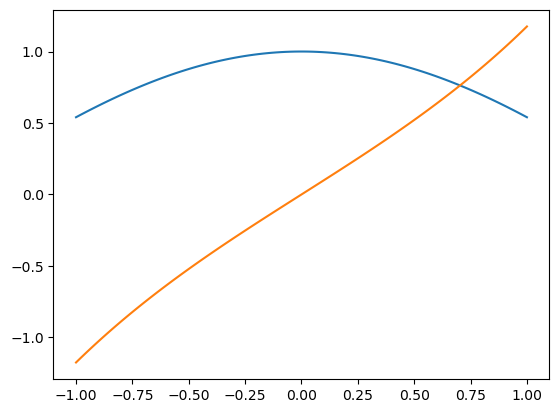

In [92]:
using PyPlot

x = range(1, -1, length=100)
y1 = (@∂ sin(x)).(x)
y2 = (@∂ cosh(x)).(x)

figure()
PyPlot.plot(x, y1)
PyPlot.plot(x, y2)
show()

And finally macros are great for extending the syntax of the language, e.g. introduce Domain Specific Languages, cf. UFL of FEniCS. Suppose we want to write many if-elif-elif-....elif statements. In LISP the corresponding function is `cond` 

In [93]:
macro cond(cases...)
    _cond(cases)
end

function _cond(cases)
    @assert all(case -> length(case.args) == 2, cases)
    pred, tvalue = first(cases).args
        
    if length(cases) == 1
        return Expr(:if, pred, tvalue)
    else
        return Expr(:if, pred, tvalue, _cond(cases[2:end]))
    end
end

_cond (generic function with 1 method)

In [94]:
x = 1
# Let's look at the code to be compiled
# NOTE: this cannot be a function as functions arguments are evaluated at 
# call. What we would see is false, 6, true, 4 otherwise
macroexpand(Main, :(@cond (10 < 2, x+5) (3 < 4, x-2)))

:(if 10 < 2
      Main.x + 5
  else
      if 3 < 4
          Main.x - 2
      end
  end)

In [95]:
@cond (10 < 2, x+5) (3 < 4, x-2)

-1

Until this point we have generated code only using Expressions / by operating on AST / manipulating symbols. There is
however an aditional stage where we can hook into the compiler - at this stage the types (of some) not the values of
AST nodes are known. This makes it possible to generate code specialized based on type. This is an example of staged programming.

In [96]:
# Let us define a type which we intend to represent a function approximated by polynomial of certain degree
struct PolyF{N}
    body::Function
end

In [97]:
# evaluation
(ff::PolyF{N} where N)(x::Real) = ff.body(x)


In [98]:
using LinearAlgebra

function gauss_legendre(degree::Int)
  #=
  The implementation is based on eigenvalues of the matrix T that is similar to
  the Jacobi matrix J. Both are tridiagonal but the T matrix is symmetric and
  the main diagonal is 0.
  =#
  diag = zeros(degree)
  up_diag = Float64[k/sqrt(4*k^2-1) for k=1:degree-1]
  T = SymTridiagonal(diag, up_diag)
  xq, ev = eigen(T)
  wq = reshape(2*ev[1, :].^2, degree)
  return xq, wq
end

gauss_legendre(1)

([0.0], [2.0])

In [99]:
using Pkg
Pkg.add("StaticArrays")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [100]:
using StaticArrays

@generated function integrate(f::PolyF{N}) where N
    # Lets generate the quadrature points and weights 
    Core.print("$N <<<")
    xq, wq = gauss_legendre(N)
    size = length(xq)
    # Other option
    
    wq = SVector{size, Float64}(wq)
    quote
        fxq = SVector{$(size), Float64}(f.($(xq)))
        sum(fxq.*($(wq)))
    end
    #quote
    #    sum(f.($(xq)).*$(wq))
    #end
end

# FIXME: compare
function integrate(f, N::Integer)
    xq, wq = gauss_legendre(N)
    size = length(xq)
    sum(f.(xq).*wq)
end

integrate (generic function with 2 methods)

In [101]:
integrate(PolyF{10}(x -> cos(x)))

10 <<<

1.6829419696157921

In [102]:
# JIT kicks in for new types, note new N(degree) implies new type
@time integrate(PolyF{22}(x -> cos(x)))

22 <<<  0.300077 seconds (770.32 k allocations: 38.563 MiB, 97.74% compilation time)


1.6829419696157948

In [103]:
# Call it again same degree - no JIT
@time integrate(PolyF{22}(x -> cos(x)))

  0.003249 seconds (565 allocations: 34.791 KiB, 96.33% compilation time)


1.6829419696157948

In [104]:
# And again, with diffrent body but same degre - no JIT
@time integrate(PolyF{22}(x -> sin(x)))

  0.003236 seconds (565 allocations: 34.791 KiB, 96.26% compilation time)


-2.2898349882893854e-16

In [105]:
N = 1000
# Some speed difference shows for large N
ans0 = @time integrate(cos, N)
ans1 = @time integrate(PolyF{N}(x -> cos(x)))

  0.204996 seconds (354.42 k allocations: 28.285 MiB, 71.38% compilation time)
1000 <<<  4.482390 seconds (10.38 M allocations: 457.777 MiB, 99.96% compilation time)


1.6829419696157941